# AI-driven morphoclimatic regional frequency modelling of sub-daily rainfall-extremes
**Authors**: Chiara Angileri, Niccolò Marzi, Shola Oshodi

## 0. Importing libraries

In [1]:
colab = False

if colab:
    !pip install fitter
    !pip install pydot
    !pip install graphviz
    from pathlib import Path
    from google.colab import drive
    drive.mount('/content/drive')

import pandas as pd
import numpy as np
from itertools import chain
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import metrics

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
from tensorflow.keras import callbacks
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from scipy import stats

from utils import util

C:\Users\chiar\AppData\Local\Temp\ipykernel_12220\2575568485.py:11: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
from importlib import reload  
from utils import util
util = reload(util)

In [3]:
# Set random seed for reproducibility
def fix_random_seed(seed):
    np.random.seed(seed)
    tf.random.set_seed(seed)

seed=84 #24 SI, 42 NO, 84 SI
fix_random_seed(seed)

## 1. Load and inspect the dataset

### 1.1. Load data

In [4]:
df, df_indexes_test = util.load_data(colab)
print(df.columns)

Index(['ID', 'Nome', 'HMerit_mean(m)', 'HMerit_stdev(m)', 'Slope_mean(deg)',
       'Slope_stdev(deg)', 'Aspect_mean(deg)', 'Aspect_stdev(deg)',
       'MinDistAdriaticC_(km)', 'OrogrAdri_mean (m)', 'OrogrAdri_stdev(m)',
       'OrogrAdri_max(m)', 'MinDistTirrenicC_(km)', 'OrograTirr_mean(m)',
       'OrograTirr_stdev(m)', 'OrograTirr_max(m)', 'MAP(mm)', 'MASnowP(mm)',
       'VarClimPT(mm)', 'VarClimSowP(mm)', 'X', 'Y', 'duration[h]', 'AMS',
       'mean_IdD', 'loc', 'scale', '99perc', '95perc', '80perc'],
      dtype='object')


In [5]:
df.head()

,ID,Nome,HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),MinDistAdriaticC_(km),OrogrAdri_mean (m),...,X,Y,duration[h],AMS,mean_IdD,loc,scale,99perc,95perc,80perc
0,5001,'Abetone',1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.037400,377.648461,...,633069.81,4890553.68,1,1.221239,28.250000,0.890564,0.184415,1.738901,1.438313,1.167176
1,5001,'Abetone',1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.037400,377.648461,...,633069.81,4890553.68,1,0.778761,28.250000,0.890564,0.184415,1.738901,1.438313,1.167176
2,5002,'Albareto',531.112211,40.321631,7.545648,4.469855,219.061317,121.198571,203.680776,300.679959,...,555576.92,4921743.21,1,1.219018,33.469565,0.823918,0.287186,2.145015,1.676915,1.254679
3,5002,'Albareto',531.112211,40.321631,7.545648,4.469855,219.061317,121.198571,203.680776,300.679959,...,555576.92,4921743.21,1,0.979995,33.469565,0.823918,0.287186,2.145015,1.676915,1.254679
4,5002,'Albareto',531.112211,40.321631,7.545648,4.469855,219.061317,121.198571,203.680776,300.679959,...,555576.92,4921743.21,1,1.153287,33.469565,0.823918,0.287186,2.145015,1.676915,1.254679


### 1.2. Preprocess and split the dataset

In [6]:
# Clean the dataset from the columns that are not useful
to_remove = ['Nome', '99perc', '95perc', '80perc']
df = df.drop(to_remove, axis=1, inplace=False)

# Unique duration values
DURATION = df['duration[h]'].unique()
print('Durations: ', DURATION)

Durations:  [ 1  3  6 12 24]


In [7]:
df = util.standardize(df, 'gumbel')

#### 1.2.1 Split the dataset into train, validation and test

In [8]:
# Take the first 100 ID and use them to create the test sets
test_ID = df_indexes_test['ID'].to_list()[:100]

test_df = df[df['ID'].isin(test_ID)]
test_df.reset_index(drop=True, inplace=True)

# Drop the test set from df and then create the train sets and validation sets
df = df.drop(df[df['ID'].isin(test_ID)].index)
df.reset_index(drop=True, inplace=True)

validation_split = 0.1
df = df.sort_values(by=['ID'])

train_df, val_df = train_test_split(df, test_size=validation_split, shuffle=False)
train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)

In [9]:
train_df.head()

,ID,AMS,mean_IdD,loc,scale,duration[h],HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),...,MinDistTirrenicC_(km),OrograTirr_mean(m),OrograTirr_stdev(m),OrograTirr_max(m),MAP(mm),MASnowP(mm),VarClimPT(mm),VarClimSowP(mm),X,Y
0,5001.0,1.221239,28.250,0.890564,0.184415,1.0,1.492466,0.280239,0.145097,-0.375455,...,-0.884287,1.114094,0.961299,0.567896,2.185839,4.641128,1.80934,4.673003,0.433955,-0.800952
1,5001.0,0.680425,199.875,0.859361,0.219803,24.0,1.492466,0.280239,0.145097,-0.375455,...,-0.884287,1.114094,0.961299,0.567896,2.185839,4.641128,1.80934,4.673003,0.433955,-0.800952
2,5001.0,0.855535,199.875,0.859361,0.219803,24.0,1.492466,0.280239,0.145097,-0.375455,...,-0.884287,1.114094,0.961299,0.567896,2.185839,4.641128,1.80934,4.673003,0.433955,-0.800952
3,5001.0,0.945591,199.875,0.859361,0.219803,24.0,1.492466,0.280239,0.145097,-0.375455,...,-0.884287,1.114094,0.961299,0.567896,2.185839,4.641128,1.80934,4.673003,0.433955,-0.800952
4,5001.0,1.518449,199.875,0.859361,0.219803,24.0,1.492466,0.280239,0.145097,-0.375455,...,-0.884287,1.114094,0.961299,0.567896,2.185839,4.641128,1.80934,4.673003,0.433955,-0.800952


#### 1.2.2 Standardize datasets

In [10]:
train_df_std = train_df #util.standardize(train_df, 'gumbel')
val_df_std = val_df #util.standardize(val_df, 'gumbel')
test_df_std = test_df #util.standardize(test_df, 'gumbel')

In [11]:
# column ID must be integer
train_df_std['ID'] = train_df_std['ID'].astype(int)
val_df_std['ID'] = val_df_std['ID'].astype(int)
test_df_std['ID'] = test_df_std['ID'].astype(int)

# column duration[h] must be integer
train_df_std['duration[h]'] = train_df_std['duration[h]'].astype(int)
val_df_std['duration[h]'] = val_df_std['duration[h]'].astype(int)
test_df_std['duration[h]'] = test_df_std['duration[h]'].astype(int)

In [12]:
train_df_std.head()

,ID,AMS,mean_IdD,loc,scale,duration[h],HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),...,MinDistTirrenicC_(km),OrograTirr_mean(m),OrograTirr_stdev(m),OrograTirr_max(m),MAP(mm),MASnowP(mm),VarClimPT(mm),VarClimSowP(mm),X,Y
0,5001,1.221239,28.250,0.890564,0.184415,1,1.492466,0.280239,0.145097,-0.375455,...,-0.884287,1.114094,0.961299,0.567896,2.185839,4.641128,1.80934,4.673003,0.433955,-0.800952
1,5001,0.680425,199.875,0.859361,0.219803,24,1.492466,0.280239,0.145097,-0.375455,...,-0.884287,1.114094,0.961299,0.567896,2.185839,4.641128,1.80934,4.673003,0.433955,-0.800952
2,5001,0.855535,199.875,0.859361,0.219803,24,1.492466,0.280239,0.145097,-0.375455,...,-0.884287,1.114094,0.961299,0.567896,2.185839,4.641128,1.80934,4.673003,0.433955,-0.800952
3,5001,0.945591,199.875,0.859361,0.219803,24,1.492466,0.280239,0.145097,-0.375455,...,-0.884287,1.114094,0.961299,0.567896,2.185839,4.641128,1.80934,4.673003,0.433955,-0.800952
4,5001,1.518449,199.875,0.859361,0.219803,24,1.492466,0.280239,0.145097,-0.375455,...,-0.884287,1.114094,0.961299,0.567896,2.185839,4.641128,1.80934,4.673003,0.433955,-0.800952


In [13]:
train_df_std.describe()

,ID,AMS,mean_IdD,loc,scale,duration[h],HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),...,MinDistTirrenicC_(km),OrograTirr_mean(m),OrograTirr_stdev(m),OrograTirr_max(m),MAP(mm),MASnowP(mm),VarClimPT(mm),VarClimSowP(mm),X,Y
count,233218.000000,233218.000000,233218.000000,233218.000000,2.332180e+05,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000,...,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000,233218.000000
mean,11047.209328,0.999994,57.052651,0.840404,2.670913e-01,9.199200,0.024646,0.032570,0.042734,0.047496,...,-0.102764,0.028934,-0.070270,-0.067010,0.023610,0.001521,0.037728,0.004899,-0.072880,-0.075678
std,4333.130131,0.375311,31.051531,0.034366,5.204271e-02,8.280664,0.984392,0.986320,0.981766,0.976423,...,0.986101,1.052469,1.018725,1.018695,0.996458,1.002549,0.995037,1.018041,0.989454,1.016837
min,5001.000000,0.008228,5.200000,0.563792,6.394417e-304,1.000000,-1.020500,-1.181048,-1.331852,-1.503806,...,-1.470102,-1.519984,-1.779005,-1.935638,-1.583809,-0.479600,-1.528887,-0.637763,-2.037322,-1.886456
25%,8094.000000,0.746687,34.984444,0.820754,2.357013e-01,3.000000,-0.708747,-0.817296,-0.887690,-0.666054,...,-0.984027,-0.582172,-0.864855,-0.799420,-0.757122,-0.452740,-0.764904,-0.515773,-0.969827,-0.868411
50%,12005.000000,0.931278,49.674286,0.841520,2.668687e-01,6.000000,-0.264208,-0.091967,0.073687,0.116867,...,-0.148547,-0.118672,-0.208966,-0.251402,-0.210103,-0.420647,-0.187105,-0.435802,0.079379,-0.371707
75%,16065.000000,1.171738,70.343750,0.862298,2.976202e-01,12.000000,0.480086,0.640557,0.730073,0.713190,...,0.563731,0.423661,0.582830,0.456927,0.596341,-0.225321,0.667556,-0.095920,0.699596,0.724815
max,20034.000000,6.288661,318.742857,1.000000,6.725157e-01,24.000000,5.244876,3.734721,2.928541,3.520526,...,2.408305,5.536860,3.648605,3.272980,4.323812,7.312002,3.537003,6.218626,2.054450,2.471653


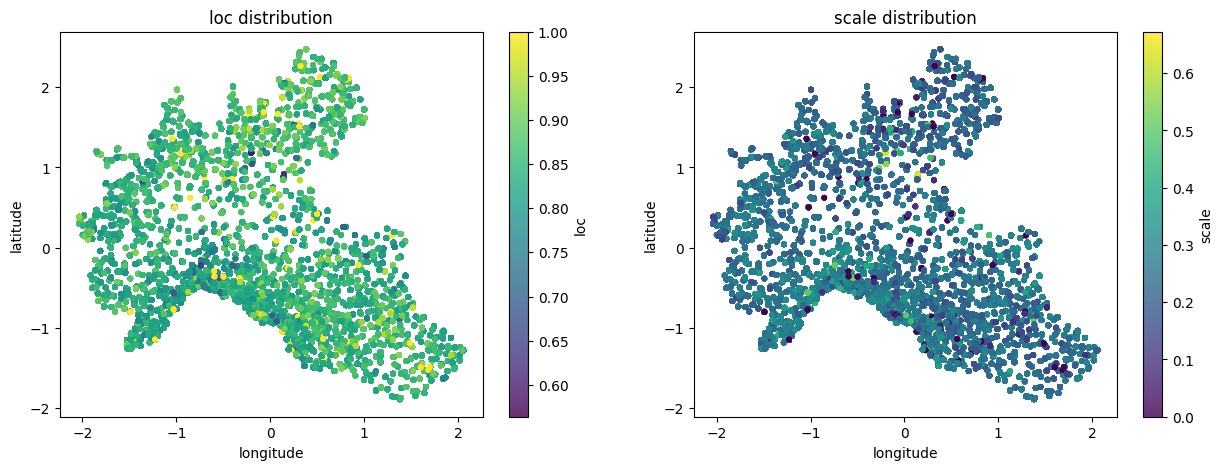

In [14]:
util.geographic_plot(train_df_std, 'loc', 'scale')

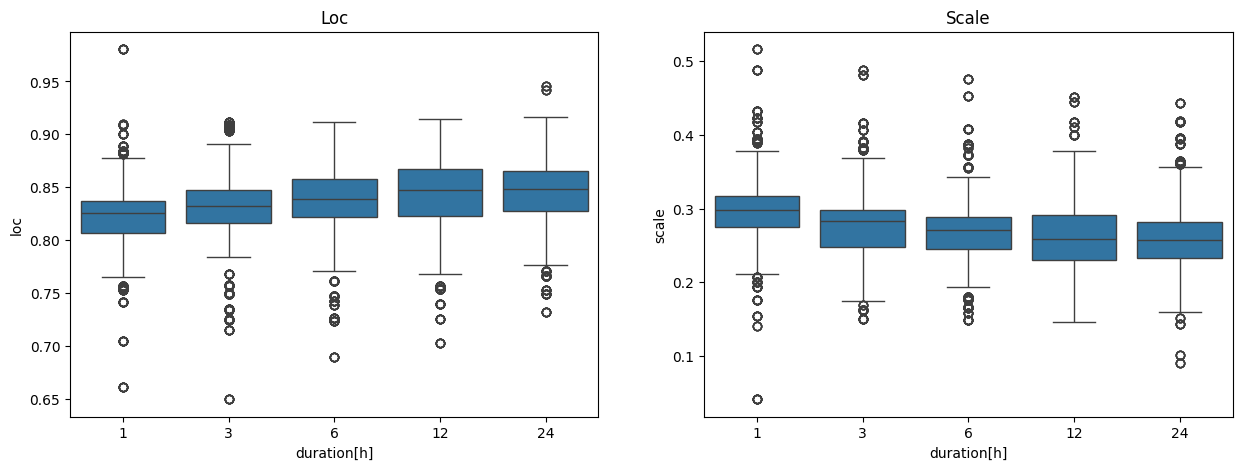

In [15]:
#boxplot of loc and scale
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.boxplot(x='duration[h]', y='loc', data=test_df_std, ax=ax[0])
ax[0].set_title('Loc')

sns.boxplot(x='duration[h]', y='scale', data=test_df_std, ax=ax[1])
ax[1].set_title('Scale')

plt.show()

In [16]:
AMS_count = test_df_std.groupby(['ID','duration[h]'])['AMS'].count()
AMS_count = pd.DataFrame(AMS_count)
AMS_count.columns = ['count']
AMS_count['loc'] = test_df_std.groupby(['ID','duration[h]'])['loc'].mean() #prendo la media tanto lo stesso valore è ripetuto
AMS_count['scale'] = test_df_std.groupby(['ID','duration[h]'])['scale'].mean()

AMS_count.head(15)

count       loc     scale
ID   duration[h]                           
5005 1               64  0.825731  0.286071
     3               64  0.828158  0.281009
     6               64  0.832412  0.271395
     12              64  0.837870  0.275187
     24              64  0.846214  0.259406
5007 1               20  0.834123  0.286670
     3               20  0.794667  0.330951
     6               20  0.817620  0.306639
     12              20  0.857670  0.262769
     24              20  0.880146  0.225763
5015 1               76  0.858022  0.251708
     3               76  0.879860  0.209240
     6               77  0.880802  0.205946
     12              78  0.877962  0.203477
     24              77  0.868152  0.221819

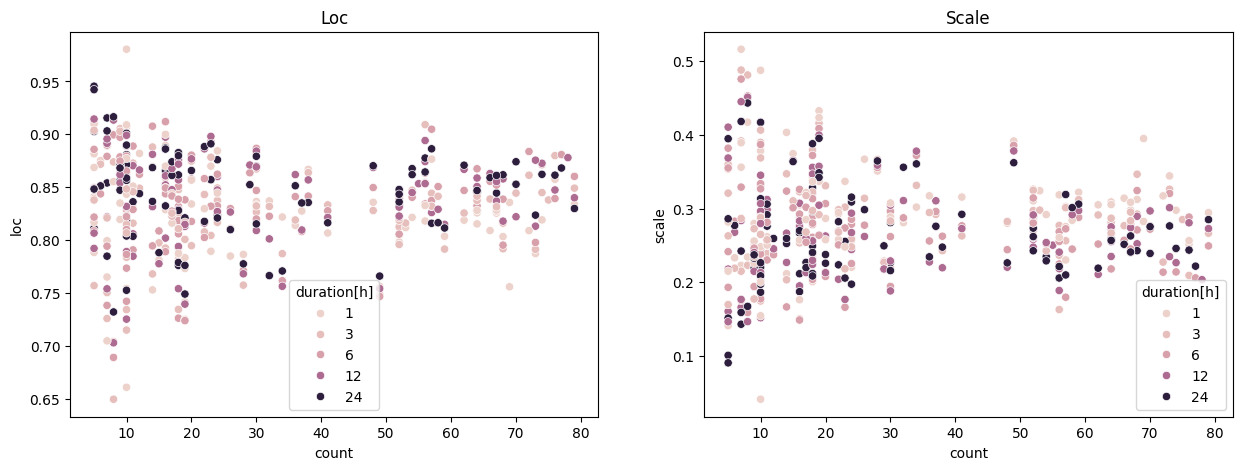

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.scatterplot(x='count', y='loc', data=AMS_count, ax=ax[0], hue='duration[h]')
ax[0].set_title('Loc')

sns.scatterplot(x='count', y='scale', data=AMS_count, ax=ax[1], hue='duration[h]')
ax[1].set_title('Scale')

plt.show()

### 1.3. Prepare data for training

In [18]:
# sort the dataframes by ID and then by duration
train_df_std = train_df_std.sort_values(by=['ID', 'duration[h]'])
val_df_std = val_df_std.sort_values(by=['ID', 'duration[h]'])
test_df_std = test_df_std.sort_values(by=['ID', 'duration[h]'])

# create a dict to store the indexes of same durations
durations_indexes_train = {}
for duration in DURATION:
    durations_indexes_train[duration] = train_df_std[train_df_std['duration[h]'] == duration].index

durations_indexes_val = {}
for duration in DURATION:
    durations_indexes_val[duration] = val_df_std[val_df_std['duration[h]'] == duration].index

durations_indexes_test = {}
for duration in DURATION:
    durations_indexes_test[duration] = test_df_std[test_df_std['duration[h]'] == duration].index

In [19]:
train_df_std.columns

Index(['ID', 'AMS', 'mean_IdD', 'loc', 'scale', 'duration[h]',
       'HMerit_mean(m)', 'HMerit_stdev(m)', 'Slope_mean(deg)',
       'Slope_stdev(deg)', 'Aspect_mean(deg)', 'Aspect_stdev(deg)',
       'MinDistAdriaticC_(km)', 'OrogrAdri_mean (m)', 'OrogrAdri_stdev(m)',
       'OrogrAdri_max(m)', 'MinDistTirrenicC_(km)', 'OrograTirr_mean(m)',
       'OrograTirr_stdev(m)', 'OrograTirr_max(m)', 'MAP(mm)', 'MASnowP(mm)',
       'VarClimPT(mm)', 'VarClimSowP(mm)', 'X', 'Y'],
      dtype='object')

In [20]:
# take all the columns except 'ID', 'AMS', 'mean_IdD' as input, and 'AMS' as output
columns = train_df_std.columns
input_columns = columns[5:]  
output_column = 'AMS'
parameters_columns = ['ID', 'duration[h]', 'loc', 'scale']
print('Input columns: ', input_columns)

Input columns:  Index(['duration[h]', 'HMerit_mean(m)', 'HMerit_stdev(m)', 'Slope_mean(deg)',
       'Slope_stdev(deg)', 'Aspect_mean(deg)', 'Aspect_stdev(deg)',
       'MinDistAdriaticC_(km)', 'OrogrAdri_mean (m)', 'OrogrAdri_stdev(m)',
       'OrogrAdri_max(m)', 'MinDistTirrenicC_(km)', 'OrograTirr_mean(m)',
       'OrograTirr_stdev(m)', 'OrograTirr_max(m)', 'MAP(mm)', 'MASnowP(mm)',
       'VarClimPT(mm)', 'VarClimSowP(mm)', 'X', 'Y'],
      dtype='object')


In [21]:
inputs_train = train_df_std[input_columns]
outputs_train = train_df_std[output_column]
parameters_train = train_df_std[parameters_columns]

inputs_val = val_df_std[input_columns]
outputs_val = val_df_std[output_column]
parameters_val = val_df_std[parameters_columns]

inputs_test = test_df_std[input_columns]
outputs_test = test_df_std[output_column]
parameters_test = test_df_std[parameters_columns]

In [22]:
#make ohe for duration

inputs_train = pd.get_dummies(inputs_train, columns=['duration[h]'])
inputs_val = pd.get_dummies(inputs_val, columns=['duration[h]'])
inputs_test = pd.get_dummies(inputs_test, columns=['duration[h]'])

for duration in DURATION:
    inputs_train['duration[h]_'+str(duration)] = inputs_train['duration[h]_'+str(duration)].astype(int)
    inputs_val['duration[h]_'+str(duration)] = inputs_val['duration[h]_'+str(duration)].astype(int)
    inputs_test['duration[h]_'+str(duration)] = inputs_test['duration[h]_'+str(duration)].astype(int)

inputs_train

,HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),MinDistAdriaticC_(km),OrogrAdri_mean (m),OrogrAdri_stdev(m),OrogrAdri_max(m),...,MASnowP(mm),VarClimPT(mm),VarClimSowP(mm),X,Y,duration[h]_1,duration[h]_3,duration[h]_6,duration[h]_12,duration[h]_24
0,1.492466,0.280239,0.145097,-0.375455,2.382086,0.222372,-0.501572,0.431856,0.617256,0.685301,...,4.641128,1.809340,4.673003,0.433955,-0.800952,1,0,0,0,0
15,1.492466,0.280239,0.145097,-0.375455,2.382086,0.222372,-0.501572,0.431856,0.617256,0.685301,...,4.641128,1.809340,4.673003,0.433955,-0.800952,1,0,0,0,0
5,1.492466,0.280239,0.145097,-0.375455,2.382086,0.222372,-0.501572,0.431856,0.617256,0.685301,...,4.641128,1.809340,4.673003,0.433955,-0.800952,0,1,0,0,0
6,1.492466,0.280239,0.145097,-0.375455,2.382086,0.222372,-0.501572,0.431856,0.617256,0.685301,...,4.641128,1.809340,4.673003,0.433955,-0.800952,0,1,0,0,0
7,1.492466,0.280239,0.145097,-0.375455,2.382086,0.222372,-0.501572,0.431856,0.617256,0.685301,...,4.641128,1.809340,4.673003,0.433955,-0.800952,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233201,1.388059,0.794012,0.723450,1.168126,-0.481020,0.092271,1.917143,0.718205,1.647284,1.950180,...,1.506071,0.839122,1.687942,-1.847247,1.192131,0,0,0,0,1
233202,1.388059,0.794012,0.723450,1.168126,-0.481020,0.092271,1.917143,0.718205,1.647284,1.950180,...,1.506071,0.839122,1.687942,-1.847247,1.192131,0,0,0,0,1
233203,1.388059,0.794012,0.723450,1.168126,-0.481020,0.092271,1.917143,0.718205,1.647284,1.950180,...,1.506071,0.839122,1.687942,-1.847247,1.192131,0,0,0,0,1
233204,1.388059,0.794012,0.723450,1.168126,-0.481020,0.092271,1.917143,0.718205,1.647284,1.950180,...,1.506071,0.839122,1.687942,-1.847247,1.192131,0,0,0,0,1


In [23]:
#MAP
inputs_train_map = inputs_train[['MAP(mm)','duration[h]_1','duration[h]_3','duration[h]_6','duration[h]_12','duration[h]_24']]
inputs_val_map = inputs_val[['MAP(mm)','duration[h]_1','duration[h]_3','duration[h]_6','duration[h]_12','duration[h]_24']]
inputs_test_map = inputs_test[['MAP(mm)','duration[h]_1','duration[h]_3','duration[h]_6','duration[h]_12','duration[h]_24']]

inputs_train_map

,MAP(mm),duration[h]_1,duration[h]_3,duration[h]_6,duration[h]_12,duration[h]_24
0,2.185839,1,0,0,0,0
15,2.185839,1,0,0,0,0
5,2.185839,0,1,0,0,0
6,2.185839,0,1,0,0,0
7,2.185839,0,1,0,0,0
...,...,...,...,...,...,...
233201,-0.125310,0,0,0,0,1
233202,-0.125310,0,0,0,0,1
233203,-0.125310,0,0,0,0,1
233204,-0.125310,0,0,0,0,1


In [24]:
#PCA
inputs_train_pca = util.make_pca(inputs_train, 5)
inputs_val_pca = util.make_pca(inputs_val, 5)
inputs_test_pca = util.make_pca(inputs_test, 5)

inputs_train_pca


,0,1,2,3,4
0,4.122771,-0.393521,-0.708337,5.286269,0.040013
1,4.122771,-0.393521,-0.708337,5.286269,0.040013
2,4.122777,-0.393565,-0.708371,5.286445,0.040039
3,4.122777,-0.393565,-0.708371,5.286445,0.040039
4,4.122777,-0.393565,-0.708371,5.286445,0.040039
...,...,...,...,...,...
233213,5.980451,1.973480,2.164376,-0.433023,0.024087
233214,5.980451,1.973480,2.164376,-0.433023,0.024087
233215,5.980451,1.973480,2.164376,-0.433023,0.024087
233216,5.980451,1.973480,2.164376,-0.433023,0.024087


## 2. Model definition

#### 2.1 Base model

In [25]:
def build_nn_gumbel_model(input_shape, hidden, seed):
    model_in = keras.Input(shape=input_shape, dtype='float64')
    x = model_in
    
    for h in hidden:
        x = layers.Dense(h, activation='relu',kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed))(x)
    
    mu_logsig = layers.Dense(2, activation='linear',kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed))(x)

    lf = lambda t: tfp.distributions.Gumbel(loc=t[:, :1], scale=(1e-6)+tf.math.exp(t[:, 1:]))
    model_out = tfp.layers.DistributionLambda(lf)(mu_logsig)
    model = keras.Model(model_in, model_out)
    
    return model

## 3. Training

### 3.1  MAP Training

In [26]:
y_train  = outputs_train.values
y_val = outputs_val.values
y_test = outputs_test.values

In [27]:
# Parameters for the training
batch_size = 128
epochs = 90 
lr = 1e-3
patience = 30
loss_prof = lambda y_true, dist: -dist.log_prob(y_true)

Training the model with only MAP descriptor...



Epoch 1/90

1823/1823 [==============================] - 5s 2ms/step - loss: 0.3257 - val_loss: 0.2657
Epoch 2/90
1823/1823 [==============================] - 4s 2ms/step - loss: 0.3124 - val_loss: 0.2894
Epoch 3/90
1823/1823 [==============================] - 4s 2ms/step - loss: 0.3105 - val_loss: 0.2750
Epoch 4/90
1823/1823 [==============================] - 4s 2ms/step - loss: 0.3093 - val_loss: 0.2579
Epoch 5/90
1823/1823 [==============================] - 4s 2ms/step - loss: 0.3084 - val_loss: 0.2586
Epoch 6/90
1823/1823 [==============================] - 4s 2ms/step - loss: 0.3078 - val_loss: 0.2681
Epoch 7/90
1823/1823 [==============================] - 4s 2ms/step - loss: 0.3073 - val_loss: 0.2602
Epoch 8/90
1823/1823 [==============================] - 4s 2ms/step - loss: 0.3072 - val_loss: 0.2584
Epoch 9/90
1823/1823 [==============================] - 4s 2ms/step - loss: 0.3069 - val_loss: 0.2729
Epoch 10/90
1823/1823 [==============================] - 4s 2ms/step - loss: 0.3

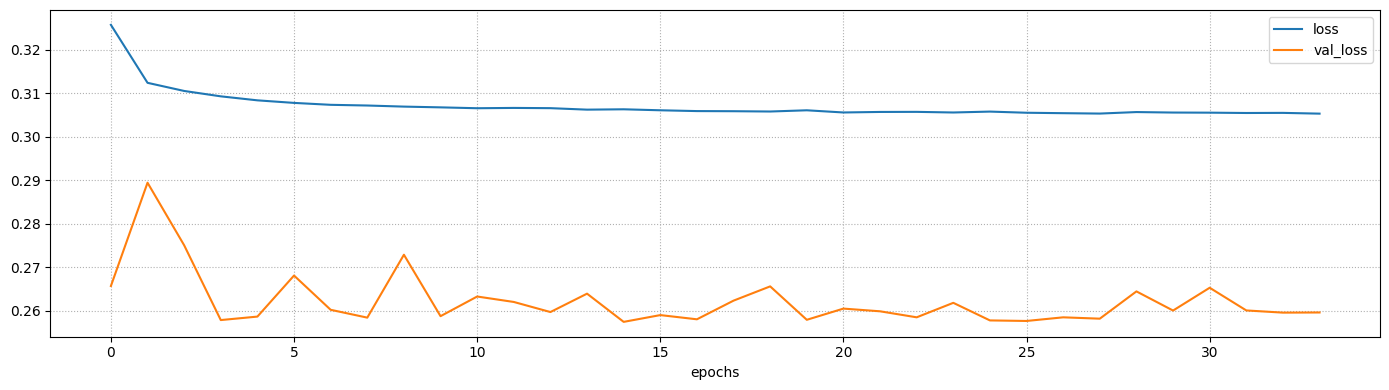

Final loss: 0.3053 (training), 0.2596 (validation)


In [28]:
X_train_map = inputs_train_map.values
X_val_map = inputs_val_map.values
X_test_map = inputs_test_map.values

print('Training the model with only MAP descriptor...')
map_model = build_nn_gumbel_model(input_shape=(X_train_map.shape[1],), hidden=[256,128], seed=seed) #[256,128]
history = util.train_nn_model(map_model, X_train_map, y_train, batch_size, loss_prof, lr, epochs, verbose=1, patience=patience, validation_data=(X_val_map, y_val))
util.plot_training_history(history, figsize=(14, 4))

### 3.2 Full-model

Training the model with all morphoclimatic descriptors...
Epoch 1/90
1823/1823 [==============================] - 6s 3ms/step - loss: 0.3416 - val_loss: 0.3100
Epoch 2/90
1823/1823 [==============================] - 4s 2ms/step - loss: 0.3074 - val_loss: 0.2886
Epoch 3/90
1823/1823 [==============================] - 4s 2ms/step - loss: 0.3022 - val_loss: 0.2684
Epoch 4/90
1823/1823 [==============================] - 4s 2ms/step - loss: 0.2997 - val_loss: 0.2943
Epoch 5/90
1823/1823 [==============================] - 4s 2ms/step - loss: 0.2981 - val_loss: 0.2684
Epoch 6/90
1823/1823 [==============================] - 4s 2ms/step - loss: 0.2959 - val_loss: 0.2653
Epoch 7/90
1823/1823 [==============================] - 4s 2ms/step - loss: 0.2945 - val_loss: 0.2567
Epoch 8/90
1823/1823 [==============================] - 4s 2ms/step - loss: 0.2939 - val_loss: 0.2719
Epoch 9/90
1823/1823 [==============================] - 4s 2ms/step - loss: 0.2927 - val_loss: 0.2655
Epoch 10/90
1823/1823 [=

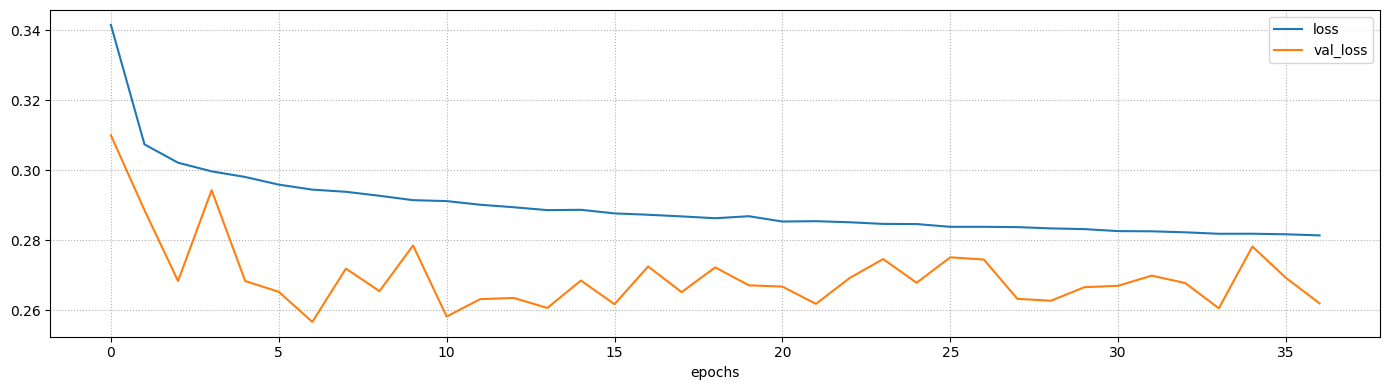

Final loss: 0.2814 (training), 0.2620 (validation)


In [29]:
X_train = inputs_train.values
X_val = inputs_val.values
X_test = inputs_test.values

print('Training the model with all morphoclimatic descriptors...')
full_model = build_nn_gumbel_model(input_shape=(X_train.shape[1],), hidden=[256,128],seed=seed) #[256,128]
history = util.train_nn_model(full_model, X_train, y_train, batch_size, loss_prof, lr, epochs, verbose=1, patience=patience, validation_data=(X_val, y_val))
util.plot_training_history(history, figsize=(14, 4))

### 3.3 PCA-model

Training the model with the PCA of the morphoclimatic descriptors...
Epoch 1/90
1823/1823 [==============================] - 5s 2ms/step - loss: 0.3470 - val_loss: 0.9741
Epoch 2/90
1823/1823 [==============================] - 4s 2ms/step - loss: 0.3106 - val_loss: 0.3141
Epoch 3/90
1823/1823 [==============================] - 4s 2ms/step - loss: 0.3061 - val_loss: 0.2775
Epoch 4/90
1823/1823 [==============================] - 4s 2ms/step - loss: 0.3037 - val_loss: 0.2635
Epoch 5/90
1823/1823 [==============================] - 4s 2ms/step - loss: 0.3028 - val_loss: 0.2677
Epoch 6/90
1823/1823 [==============================] - 4s 2ms/step - loss: 0.3016 - val_loss: 0.2719
Epoch 7/90
1823/1823 [==============================] - 4s 2ms/step - loss: 0.3007 - val_loss: 0.2614
Epoch 8/90
1823/1823 [==============================] - 4s 2ms/step - loss: 0.3004 - val_loss: 0.2646
Epoch 9/90
1823/1823 [==============================] - 4s 2ms/step - loss: 0.2998 - val_loss: 0.2773
Epoch 10/90
1

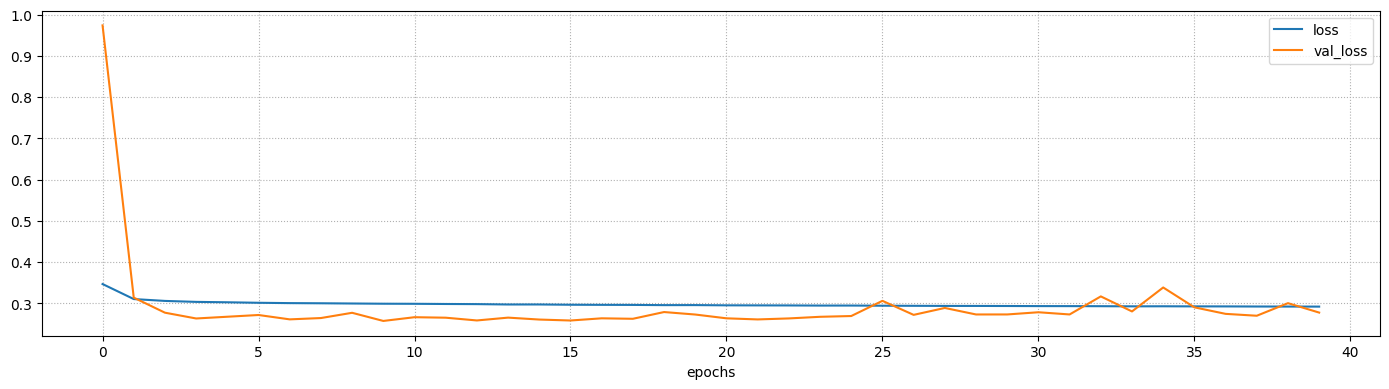

Final loss: 0.2923 (training), 0.2778 (validation)


In [30]:
X_train_pca = inputs_train_pca.values
X_val_pca = inputs_val_pca.values
X_test_pca = inputs_test_pca.values

print('Training the model with the PCA of the morphoclimatic descriptors...')
pca_model = build_nn_gumbel_model(input_shape=(X_train_pca.shape[1],), hidden=[256,128],seed=seed) #[256,128]
history = util.train_nn_model(pca_model, X_train_pca, y_train, batch_size, loss_prof, lr, epochs, verbose=1, patience=patience, validation_data=(X_val_pca, y_val))
util.plot_training_history(history, figsize=(14, 4))

## 4. Evaluation

In [31]:
'''model_names = [ 'MAP', 'Full', 'PCA']
splits = ['Train', 'Validation', 'Test']
models = [map_model, full_model, pca_model]
X_values = {'MAP':[X_train_map, X_val_map, X_test_map], 'Full':[X_train, X_val, X_test], 'PCA':[X_train_pca, X_val_pca, X_test_pca]}
y_values = [y_train, y_val, y_test]'''


dist_train_map = map_model(X_train_map)
dist_val_map = map_model(X_val_map)
dist_test_map = map_model(X_test_map)

dist_train_full = full_model(X_train)
dist_val_full = full_model(X_val)
dist_test_full = full_model(X_test)

dist_train_pca = pca_model(X_train_pca)
dist_val_pca = pca_model(X_val_pca)
dist_test_pca = pca_model(X_test_pca)


### 4.1 Distribution mean - confidence interval 

In [32]:
confidence = 0.99

Evaluation of MAP-model based on confidence intervals..


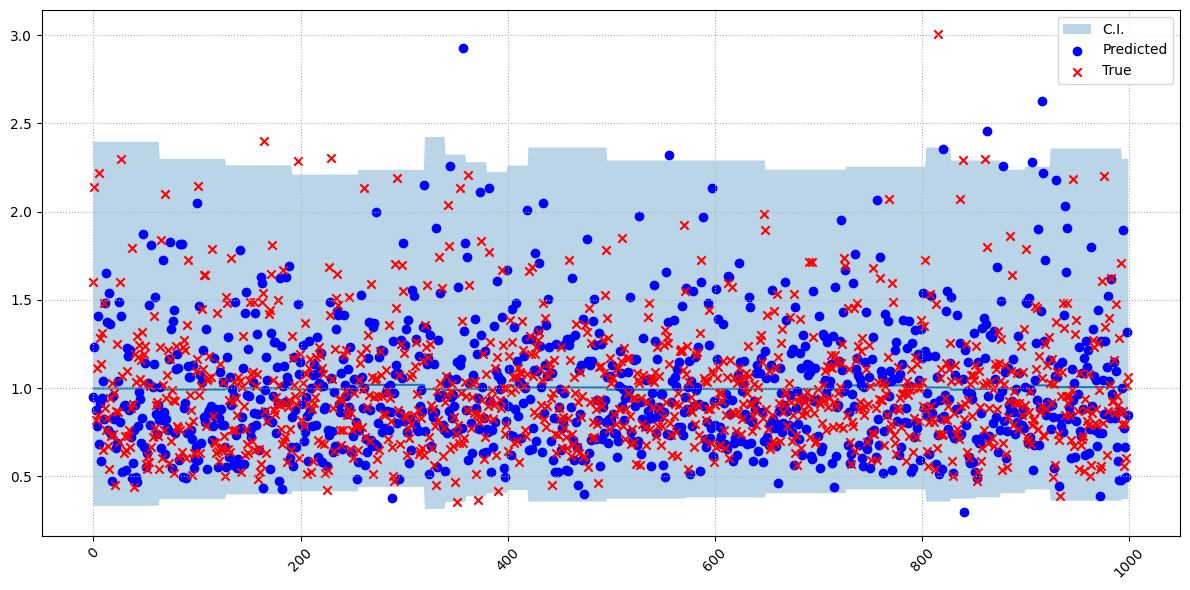

Percentage of values inside the 99% confidence interval: 98.14%


In [33]:
print('Evaluation of MAP-model based on confidence intervals..')
inside = util.percentage_in_ci(inputs_test_map, y_test, dist_test_map, confidence, distribution = 'gumbel', end = 1000)
print(f'Percentage of values inside the {confidence*100:.0f}% confidence interval: {inside:.2f}%')

Evaluation of Full-model based on confidence intervals..


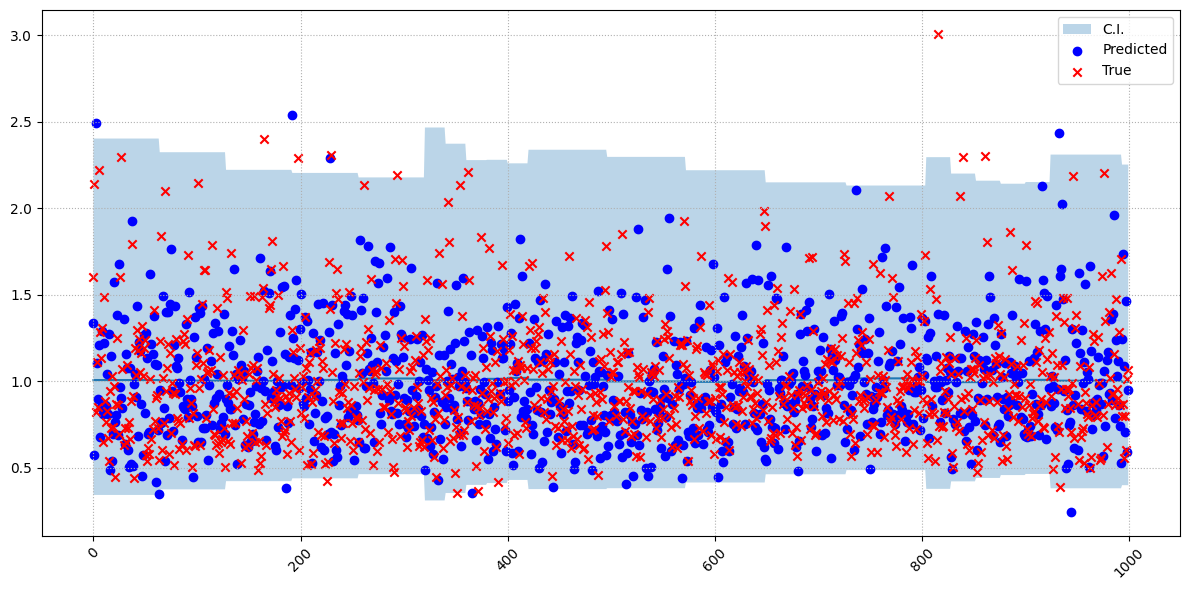

Percentage of values inside the 99% confidence interval: 98.07%


In [34]:
print('Evaluation of Full-model based on confidence intervals..')
inside = util.percentage_in_ci(inputs_test, y_test, dist_test_full, confidence, distribution = 'gumbel', end = 1000)
print(f'Percentage of values inside the {confidence*100:.0f}% confidence interval: {inside:.2f}%')

Evaluation of PCA-model based on confidence intervals..


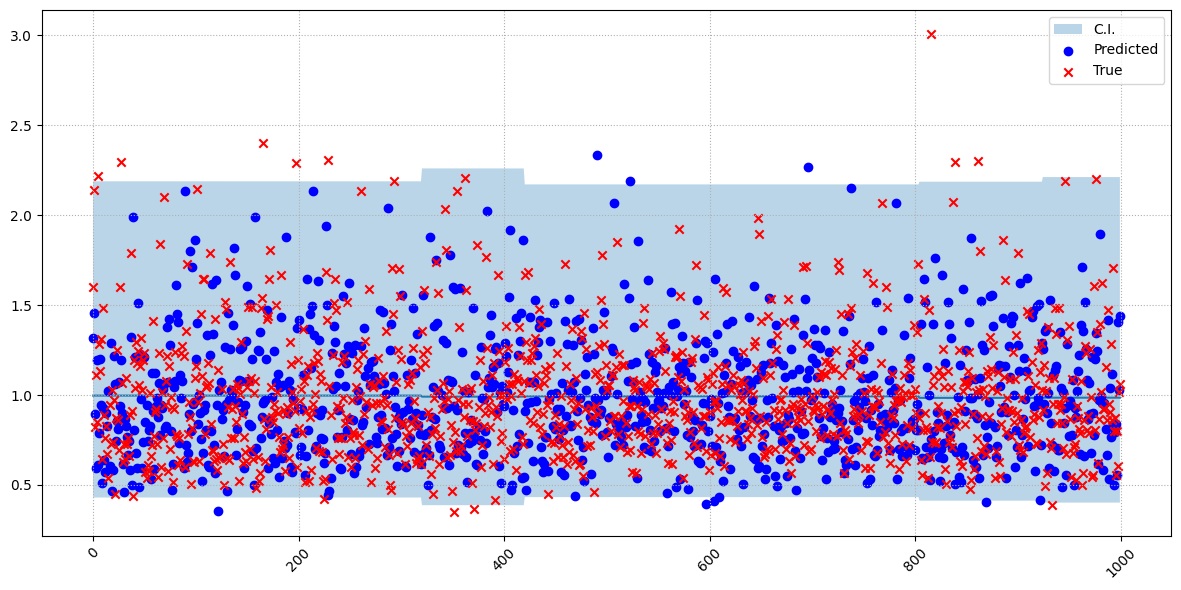

Percentage of values inside the 99% confidence interval: 97.85%


In [35]:
print('Evaluation of PCA-model based on confidence intervals..')
inside = util.percentage_in_ci(inputs_test_pca, y_test, dist_test_pca, confidence, distribution = 'gumbel', end = 1000)
print(f'Percentage of values inside the {confidence*100:.0f}% confidence interval: {inside:.2f}%')

## 5. Parameters

* Metrics on parameters from MAP-model

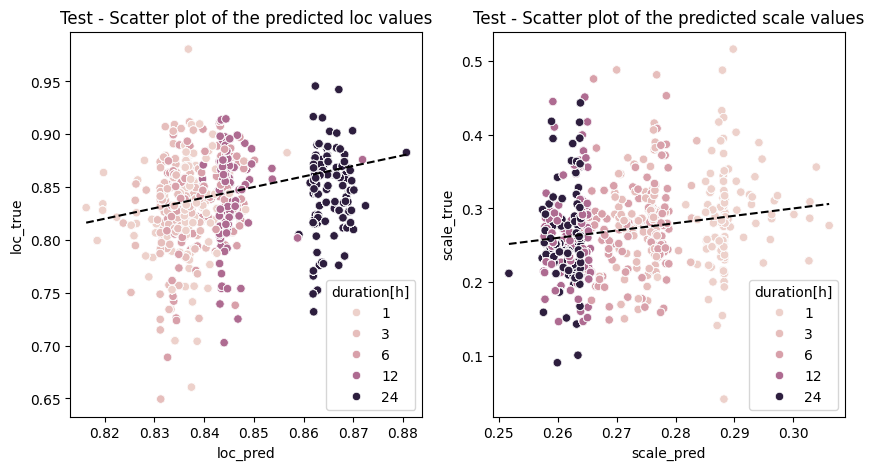

In [36]:
#_ = util.parameters_metrics(dist_train_map, parameters_train, distribution_name = 'gumbel', calculate_metrics = False, title='Train')
metrics_loc_map, metrics_scale_map = util.parameters_metrics(dist_test_map, parameters_test, indexes = durations_indexes_test, distribution_name='gumbel', remove_outliers = False)

In [37]:
print('===============LOC PARAMETER===============')
display(metrics_loc_map)
print('===============SCALE PARAMETER==============')
metrics_scale_map

===============LOC PARAMETER===============


,global,1,3,6,12,24
biasr,-0.011565,-0.015921,-0.006772,-0.003816,-0.005091,-0.026245
mape,0.031724,0.032506,0.030579,0.030977,0.030731,0.033831
pcc,0.199941,0.095523,0.071807,0.181572,0.078289,0.135485


===============SCALE PARAMETER==============


,global,1,3,6,12,24
biasr,-0.026018,-0.019797,-0.011856,-0.049025,-0.022125,-0.027286
mape,0.135852,0.136393,0.128336,0.138981,0.141151,0.134392
pcc,0.265436,0.072296,0.062156,0.202055,0.112596,0.082886


* Metrics on parameters from Full-model

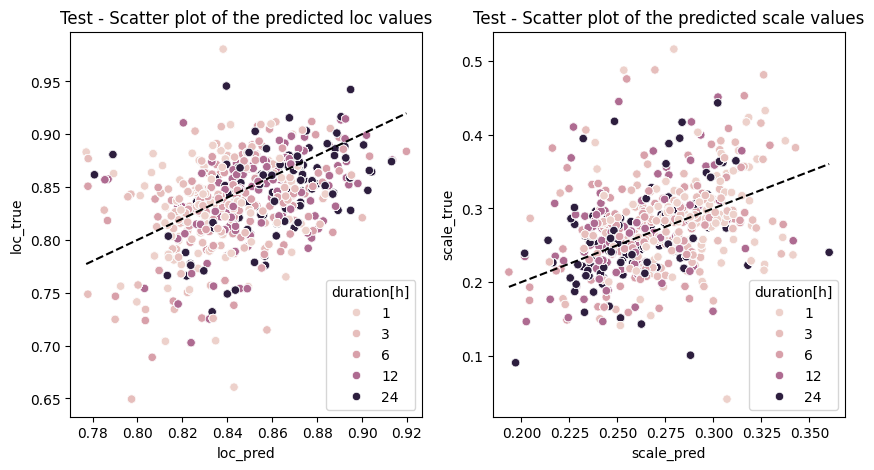

In [38]:
#_ = util.parameters_metrics(dist_train_full, parameters_train, distribution_name = 'gumbel', calculate_metrics = False, title='Train')
metrics_loc_full, metrics_scale_full = util.parameters_metrics(dist_test_full, parameters_test, indexes = durations_indexes_test, distribution_name='gumbel', remove_outliers = False)

In [39]:
print('===============LOC PARAMETER===============')
display(metrics_loc_full)
print('===============SCALE PARAMETER==============')
metrics_scale_full

===============LOC PARAMETER===============


,global,1,3,6,12,24
biasr,-0.014809,-0.013390,-0.009756,-0.011731,-0.017145,-0.022030
mape,0.032513,0.034601,0.031385,0.031754,0.032244,0.032579
pcc,0.436048,0.138207,0.388485,0.453435,0.452563,0.485188


===============SCALE PARAMETER==============


,global,1,3,6,12,24
biasr,-0.005982,-0.019510,-0.008362,-0.004810,0.003740,-0.000954
mape,0.129807,0.142587,0.122176,0.126545,0.131723,0.125990
pcc,0.455186,0.179883,0.409342,0.453074,0.446704,0.465454


* Metrics on parameters from PCA-model

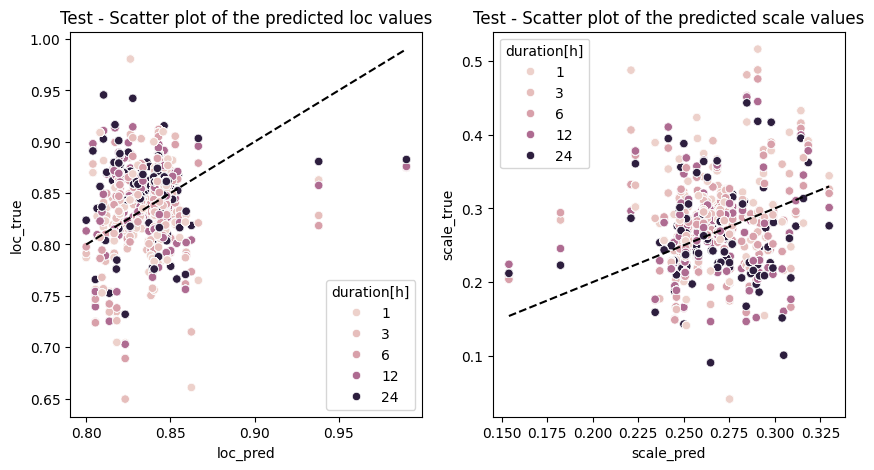

In [40]:
#_ = util.parameters_metrics(dist_train_pca, parameters_train, distribution_name = 'gumbel', calculate_metrics = False, title='Train')
metrics_loc_pca, metrics_scale_pca = util.parameters_metrics(dist_test_pca, parameters_test, indexes = durations_indexes_test, distribution_name='gumbel', remove_outliers = False)

In [41]:
print('===============LOC PARAMETER===============')
display(metrics_loc_pca)
print('===============SCALE PARAMETER==============')
metrics_scale_full

===============LOC PARAMETER===============


,global,1,3,6,12,24
biasr,-0.001180,-0.015467,-0.008069,0.001781,0.006397,0.009477
mape,0.033249,0.034317,0.031185,0.032755,0.033698,0.034289
pcc,0.182244,0.210609,0.281047,0.201470,0.127392,0.105396


===============SCALE PARAMETER==============


,global,1,3,6,12,24
biasr,-0.005982,-0.019510,-0.008362,-0.004810,0.003740,-0.000954
mape,0.129807,0.142587,0.122176,0.126545,0.131723,0.125990
pcc,0.455186,0.179883,0.409342,0.453074,0.446704,0.465454


### 5.1  Comparison between two samples extracted from "true" and predicted distribution of the same place 

True loc: 0.83, Predicted loc: 0.84
True scale: 0.29, Predicted scale: 0.30
KS statistics:  0.0212


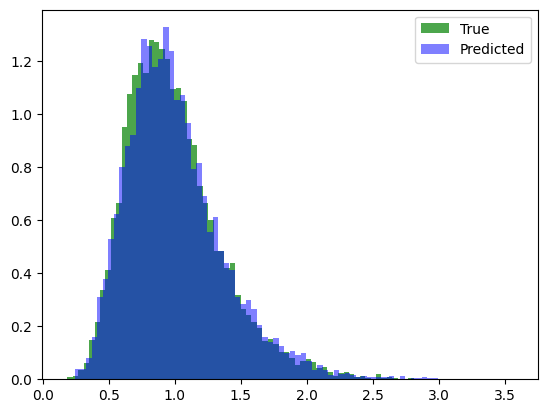

In [53]:
util.compare_samples(dist_test_full, "gumbel", parameters_test, index=1)
#util.compare_samples(dist_test_map, "gumbel", parameters_test, index=9)
#util.compare_samples(dist_test_pca, "gumbel", parameters_test, index=9)

## 6. Save results 


In [43]:
metrics_name = ['biasr', 'mape', 'pcc']
models_name = ['map', 'full', 'pca']
models_metrics = [ metrics_scale_map, metrics_scale_full, metrics_scale_pca]

In [44]:
scale_metrics = util.get_global_results(metrics_name,models_name,models_metrics)
scale_metrics

,biasr_map,biasr_full,biasr_pca,mape_map,mape_full,mape_pca,pcc_map,pcc_full,pcc_pca
global,-0.026018,-0.005982,-0.010062,0.135852,0.129807,0.146670,0.265436,0.455186,0.205754
1,-0.019797,-0.019510,0.058643,0.136393,0.142587,0.155900,0.072296,0.179883,0.253822
3,-0.011856,-0.008362,0.017904,0.128336,0.122176,0.126818,0.062156,0.409342,0.344051
6,-0.049025,-0.004810,-0.029837,0.138981,0.126545,0.141561,0.202055,0.453074,0.239020
12,-0.022125,0.003740,-0.045055,0.141151,0.131723,0.155425,0.112596,0.446704,0.118899
24,-0.027286,-0.000954,-0.052047,0.134392,0.125990,0.153648,0.082886,0.465454,0.104765


In [45]:
models_metrics = [ metrics_loc_map, metrics_loc_full, metrics_loc_pca]
loc_metrics = util.get_global_results(metrics_name,models_name,models_metrics)
loc_metrics

,biasr_map,biasr_full,biasr_pca,mape_map,mape_full,mape_pca,pcc_map,pcc_full,pcc_pca
global,-0.011565,-0.014809,-0.001180,0.031724,0.032513,0.033249,0.199941,0.436048,0.182244
1,-0.015921,-0.013390,-0.015467,0.032506,0.034601,0.034317,0.095523,0.138207,0.210609
3,-0.006772,-0.009756,-0.008069,0.030579,0.031385,0.031185,0.071807,0.388485,0.281047
6,-0.003816,-0.011731,0.001781,0.030977,0.031754,0.032755,0.181572,0.453435,0.201470
12,-0.005091,-0.017145,0.006397,0.030731,0.032244,0.033698,0.078289,0.452563,0.127392
24,-0.026245,-0.022030,0.009477,0.033831,0.032579,0.034289,0.135485,0.485188,0.105396


In [46]:
#export as pkl file  loc and scale metrics
loc_metrics.to_pickle('results/loc_metrics.pkl')
scale_metrics.to_pickle('results/scale_metrics.pkl')
